In [1]:
pip install transformers

In [2]:
#pip install tensorflow

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, TFAutoModel, TFBertForSequenceClassification, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score

## Loading Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/drive/MyDrive/archive (3)/smile-annotations-final.csv")

In [6]:
df.head()

,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap,nocode
0,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
1,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
2,614877582664835073,@Sofabsports thank you for following me back. ...,happy
3,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy
4,611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy


In [7]:
df.shape

(3084, 3)

In [8]:
df.columns= ["id", "text", "category"]

In [9]:
print(df.category.unique())

['happy' 'nocode' 'not-relevant' 'angry' 'disgust|angry' 'disgust'
 'happy|surprise' 'sad' 'surprise' 'happy|sad' 'sad|disgust' 'sad|angry'
 'sad|disgust|angry']


In [10]:
#get value count for each class
df.category.value_counts()

nocode               1571
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [11]:
df

,id,text,category
0,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
1,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
2,614877582664835073,@Sofabsports thank you for following me back. ...,happy
3,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy
4,611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy
...,...,...,...
3079,613678555935973376,MT @AliHaggett: Looking forward to our public ...,happy
3080,613294681225621504,@britishmuseum Upper arm guard?,nocode
3081,615246897670922240,@MrStuchbery @britishmuseum Mesmerising.,happy
3082,613016084371914753,@NationalGallery The 2nd GENOCIDE against #Bia...,not-relevant


In [12]:
df = df[~df.category.str.contains('\|')]
df = df[df.category != 'nocode']

#get value count for each class
df.category.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: category, dtype: int64

In [13]:
labels = df.category.unique()
labels

array(['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise'],
      dtype=object)

In [14]:
# Convert the label text into numbers
label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index

In [15]:
label_dict

{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [16]:
# Create a column with the numeric values of the catergories
df["label"] = df.category.replace(label_dict)
df

,id,text,category,label
0,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
1,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
2,614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
3,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
4,611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0
...,...,...,...,...
3077,611258135270060033,@_TheWhitechapel @Campaignforwool @SlowTextile...,not-relevant,1
3078,612214539468279808,“@britishmuseum: Thanks for ranking us #1 in @...,happy,0
3079,613678555935973376,MT @AliHaggett: Looking forward to our public ...,happy,0
3081,615246897670922240,@MrStuchbery @britishmuseum Mesmerising.,happy,0


In [17]:
#plot class distribution
#plt.figure(figsize=(10, 5))
#sns.countplot(df.category, palette='Spectral')
#plt.xlabel('Classes')
#plt.title('Class Distribution');

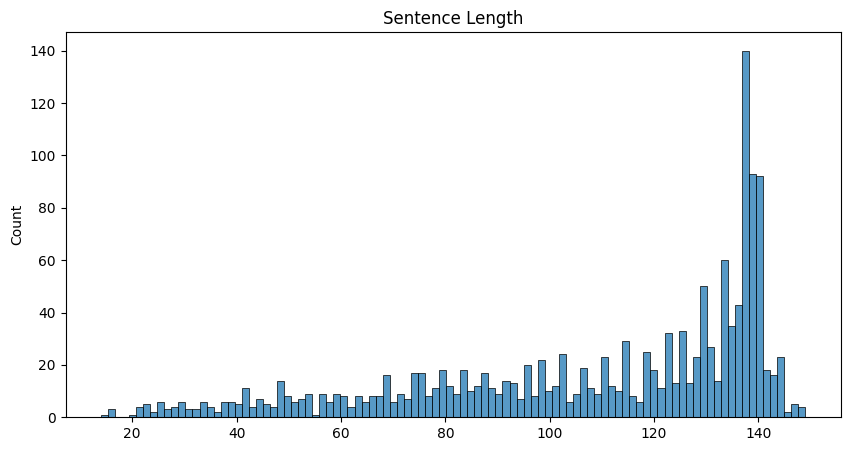

In [18]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [19]:
#find the sentence with the maximum length
max_len = max([len(sent) for sent in df.text])
print('Max length: ', max_len)
print(f'Hence, we will pad all sentence to length {max_len + 1}')

Max length:  149
Hence, we will pad all sentence to length 150


## Data Preprocessing
We preprocessing our data through 3 steps:

    Train test split
    Tokenization
    Encoding

### Train Test Split

In [20]:
#train test split
x_train, x_val, y_train, y_val = train_test_split(df.index.values,
                                                   df.label.values,
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df.label.values)

In [21]:
x_train

array([1227,  762, 1513, ...,  155, 2598,   80])

In [22]:
df['data_type'] = 'not_set'

In [23]:
df

,id,text,category,label,data_type
0,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,not_set
1,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,not_set
2,614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,not_set
3,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,not_set
4,611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,not_set
...,...,...,...,...,...
3077,611258135270060033,@_TheWhitechapel @Campaignforwool @SlowTextile...,not-relevant,1,not_set
3078,612214539468279808,“@britishmuseum: Thanks for ranking us #1 in @...,happy,0,not_set
3079,613678555935973376,MT @AliHaggett: Looking forward to our public ...,happy,0,not_set
3081,615246897670922240,@MrStuchbery @britishmuseum Mesmerising.,happy,0,not_set


In [24]:
df.loc[x_train, 'data_type'] = 'train'
df.loc[x_val, 'data_type'] = 'val'

In [25]:
#groupby count
df.groupby(['category', 'label', 'data_type']).count()

id  text
category     label data_type           
angry        2     train       48    48
                   val          9     9
disgust      3     train        5     5
                   val          1     1
happy        0     train      966   966
                   val        171   171
not-relevant 1     train      182   182
                   val         32    32
sad          4     train       27    27
                   val          5     5
surprise     5     train       30    30
                   val          5     5

### Tokenization

In [26]:
# Build the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

### Encoding

In [27]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 256,
                                                return_tensors = 'tf')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus(df[df.data_type == 'val'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 256,
                                                return_tensors = 'tf')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
encoded_data_val['token_type_ids'].shape

TensorShape([223, 256])

In [30]:
#Encode the train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
#token_type_ids_train = encoded_data_train['token_type_ids']
labels_train = tf.constant(df[df.data_type == 'train'].label.values)

In [31]:
#Encode the validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
#token_type_ids_val = encoded_data_val['token_type_ids']
labels_val = tf.constant(df[df.data_type == 'val'].label.values)

In [32]:
labels_train

<tf.Tensor: shape=(1258,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 1])>

In [33]:
#df[df.data_type == 'train'].label.values

## Set Up Model
Now we will set up our BERT model through 4 steps:

    Load Pre-trained BERT
    Create DataLoader
    Set up optimizer
    Set up scheduler

### Load Pre-trained BERT

In [34]:
# Define the checkpoint
checkpoint = 'bert-base-uncased'
# Set up BERT Pre-trained Model
model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)
#model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# Access the configuration of the model
config = model.config
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### Create a DataLoader

In [36]:
# create the data loader function
def create_data_loader(input_ids, attention_mask, labels,batch_size = 32, shuffle = True):
    dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size = len(input_ids))
    dataset = dataset.batch(batch_size)
    return dataset

In [37]:
# Using the data loader function obtain the train and validation dataset loaders
train_data_loader = create_data_loader(input_ids_train, attention_masks_train, labels_train, batch_size = 32)
val_data_loader = create_data_loader(input_ids_val, attention_masks_val, labels_val, batch_size = 32)

### Set up the optimizer and the Scheduler

In [38]:
from transformers.optimization_tf import create_optimizer

In [39]:
# Set the Parameters
learning_rate = 2e-5
epsilon = 1e-8
epochs = 10
batch_size = 32

In [40]:
# Set up the optimizer and the Scheduler
optimizer, lr_scheduler = create_optimizer(
    init_lr = learning_rate,
    num_train_steps = len(train_data_loader)*epochs,
    num_warmup_steps = int(0.1 * len(train_data_loader)),
    min_lr_ratio = 0.0,
    adam_beta1 = 0.9,
    adam_beta2 = 0.999,
    weight_decay_rate = 0.01,
    power = 1.0, )

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)

In [42]:
#optimizer
#lr_scheduler

## Train the Model
Now we will need some performance metrics to evaluate our model:

    Define the loss and accuracy metrics.
    Train the Loop
    Visualize by plotting

### Define the Loss and Accuracy Metrics

In [44]:
# Define the loss Object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
# Define the train_loss and train_accuracy
train_loss = tf.keras.metrics.Mean(name = "train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy("train_accuracy")

### The Training Loop

In [45]:
from sklearn.metrics import f1_score
from tqdm import tqdm
from tensorflow.keras.metrics import Mean

In [46]:
@tf.function
def train_step(input_ids, attention_masks, labels):
    with tf.GradientTape() as tape:
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        loss = loss_object(labels, logits)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, logits)

# Define the Evaluate function
def evaluate(model, dataloader_val):
    val_loss = Mean()
    predictions, true_vals = [], []

    for batch in dataloader_val:
        input_ids, attention_masks, labels = batch

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        loss = loss_object(labels, logits)

        val_loss(loss)

        #Convert logits and labels to numpy arrays for evaluation
        logits = logits.numpy()
        label_ids = labels.numpy()

        # Apply softmax to get the predicted class probabilities
        probabilities = tf.nn.softmax(logits, axis=1).numpy()
        predicted_class = np.argmax(probabilities, axis=1)

        predictions.extend(predicted_class)
        true_vals.extend(label_ids)

    # Calculate average loss
    val_loss_avg = val_loss.result()

    # Calculate accuracy
    true_vals = np.array(true_vals)
    predictions = np.array(predictions)
    val_accuracy = np.mean(true_vals == predictions)

    # Calculate F1 score
    f1_weighted = f1_score(true_vals, predictions, average='weighted')

    return val_loss_avg, val_accuracy, f1_weighted

epochs = 10

# Initialize the variables
best_val_accuracy = float("inf") # Initialize with a high value
train_loss_list, train_accuracy_list = [], []
val_loss_list, val_accuracy_list, val_f1_list = [], [], []


for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()

    for batch in train_data_loader:
        input_ids, attention_masks, labels = batch
        train_step(input_ids, attention_masks, labels)

    # Record the training loss and accuracy
    train_loss_list.append(train_loss.result())
    train_accuracy_list.append(train_accuracy.result())

    # Evaluate the model on the validation set
    val_loss, val_accuracy, val_f1 = evaluate(model, val_data_loader)

    # Record the validation metrics
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    val_f1_list.append(val_f1)

    print(f"Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()}")
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation F1 Score (weighted): {val_f1}")

    # Save the model after each epoch
    # model.save_pretrained(f'Models/BERT_ft_epoch{epoch + 1}')
    if val_accuracy < best_val_accuracy:
      best_val_accuracy = val_accuracy
      model.save_pretrained(f'Models/BERT1_best_model')

Epoch 1, Loss: 1.1137117147445679, Accuracy: 0.7217805981636047
Validation Loss: 0.8113375902175903, Validation Accuracy: 0.7668161434977578, Validation F1 Score (weighted): 0.6656119824269878
Epoch 2, Loss: 0.6980252265930176, Accuracy: 0.7861685156822205
Validation Loss: 0.6121715307235718, Validation Accuracy: 0.7937219730941704, Validation F1 Score (weighted): 0.7368991508443851
Epoch 3, Loss: 0.4367184638977051, Accuracy: 0.862480103969574
Validation Loss: 0.5645415186882019, Validation Accuracy: 0.8071748878923767, Validation F1 Score (weighted): 0.7604161769648836
Epoch 4, Loss: 0.3056691586971283, Accuracy: 0.8926867842674255
Validation Loss: 0.4794881045818329, Validation Accuracy: 0.8475336322869955, Validation F1 Score (weighted): 0.8239634322283237
Epoch 5, Loss: 0.20275244116783142, Accuracy: 0.9419713616371155
Validation Loss: 0.4737653434276581, Validation Accuracy: 0.8609865470852018, Validation F1 Score (weighted): 0.8390333802095608
Epoch 6, Loss: 0.1502762734889984, 

### Plot the F1_score, loss and accuracy metrics

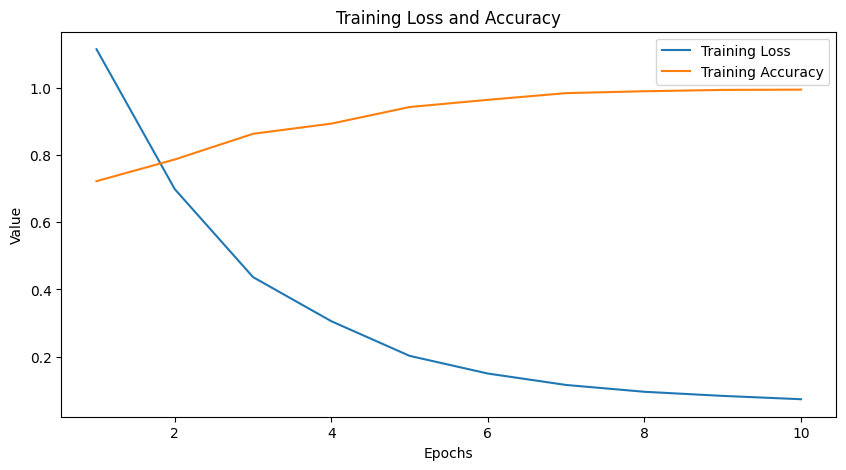

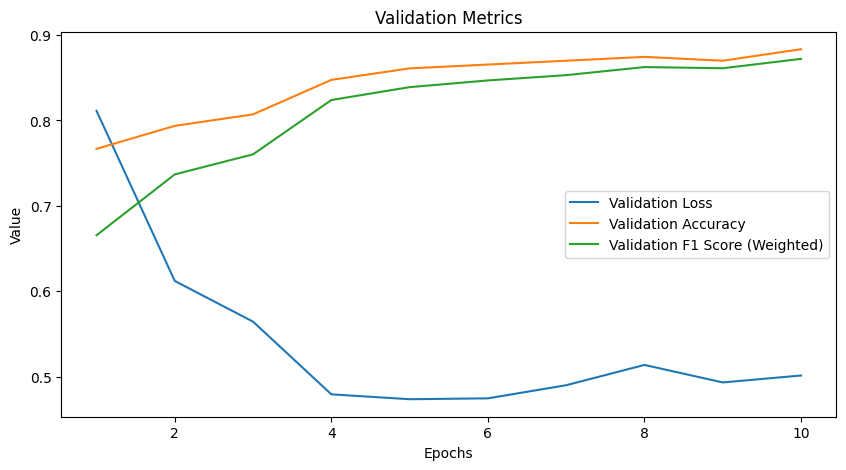

In [47]:
#Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

#Plot the validation loss, accuracy, and F1 score
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')
plt.plot(range(1, epochs + 1), val_accuracy_list, label='Validation Accuracy')
plt.plot(range(1, epochs + 1), val_f1_list, label='Validation F1 Score (Weighted)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Metrics')
plt.legend()
plt.show()